Librerias

In [36]:
# --- LIBRERÍAS NECESARIAS ---

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation, PillowWriter

import geopandas as gpd
import pandas as pd
import numpy as np

import osmnx as ox
from shapely.geometry import Point

# Para mostrar GIFs en notebooks
from IPython.display import Image

Carga de datos

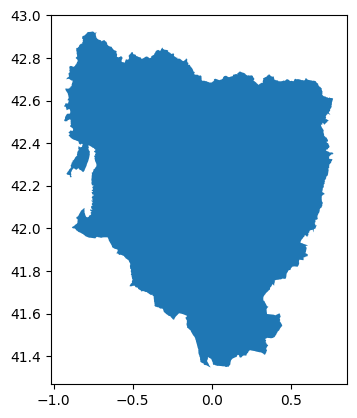

In [37]:
place = "Huesca, Spain"

tags_peaks = {"natural": "peak"}      # Montañas
tags_ski   = {"aerialway": True}      # Estaciones de esquí (telesillas, telecabinas)

region = ox.geocode_to_gdf(place)
region.plot()

mountains = ox.features.features_from_place(place, tags_peaks)
ski       = ox.features.features_from_place(place, tags_ski)


Clasificamos los datos



In [38]:
# Convertir altitud a número
mountains["ele"] = pd.to_numeric(mountains["ele"], errors="coerce")

# Tresmiles
mountains["category"] = np.where(mountains["ele"] >= 3000, "summit", None)
mountains = mountains[mountains["category"].notna()]

# Estaciones de esquí
ski["category"] = "ski"

# Unir datasets
points = pd.concat([mountains, ski], ignore_index=True)




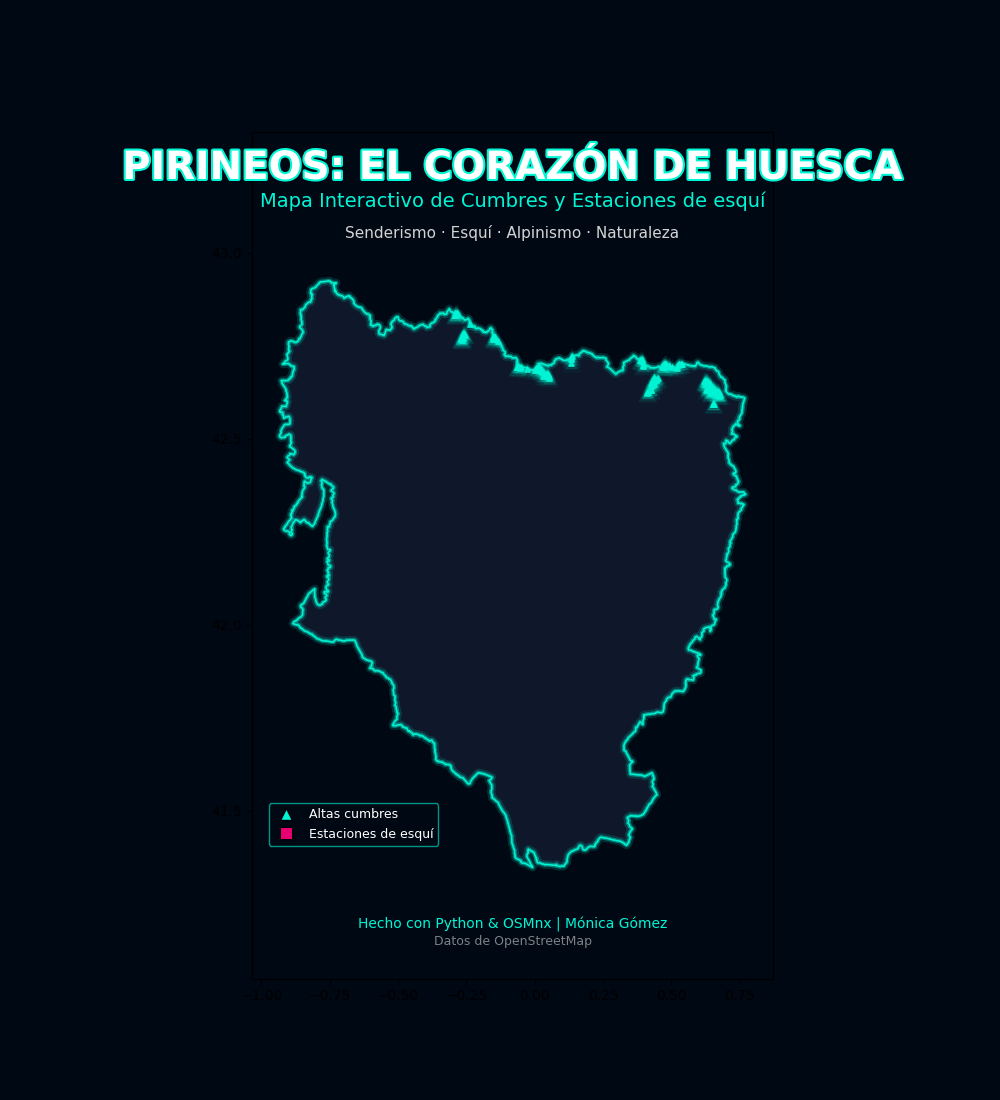

In [40]:
# --- 1. Definimos las dos categorias---

CATEGORY_COLORS = {
    "summit": "#00f5d4",   # cian → tresmiles
    "ski": "#ff007f"       # rosa → estaciones de esquí
}

MARKERS = {
    "summit": "^",   # triángulo
    "ski": "s"       # cuadrado
}

data = points   # usar el dataset combinado




fig, ax = plt.subplots(figsize=(10, 11), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

# --- 2. Mapa base con glow ---
region.plot(ax=ax, color=LAND_COLOR, zorder=1)

# Glow multicapa en la frontera
region.boundary.plot(ax=ax, color=BORDER_GLOW, linewidth=6, alpha=0.08, zorder=2)
region.boundary.plot(ax=ax, color=BORDER_GLOW, linewidth=3, alpha=0.25, zorder=3)
region.boundary.plot(ax=ax, color=BORDER_GLOW, linewidth=1, alpha=0.8, zorder=4)

# --- 3. Ajuste de zoom ---
minx, miny, maxx, maxy = region.total_bounds
ax.set_xlim(minx - 0.1, maxx + 0.1)
ax.set_ylim(miny - 0.3, maxy + 0.4)


# --- 5. Títulos con halo neon ---
ax.text(
    0.5, 0.98, "PIRINEOS: EL CORAZÓN DE HUESCA",
    ha="center", va="top", fontsize=28, color="white", weight="bold",
    transform=ax.transAxes,
    path_effects=[pe.withStroke(linewidth=3, foreground=BORDER_GLOW)]
)

ax.text(
    0.5, 0.93, "Mapa Interactivo de Cumbres y Estaciones de esquí",
    ha="center", va="top", fontsize=14, color=BORDER_GLOW,
    transform=ax.transAxes
)

ax.text(
    0.5, 0.89, "Senderismo · Esquí · Alpinismo · Naturaleza",
    ha="center", va="top", fontsize=11, color="lightgray",
    transform=ax.transAxes
)

# Pie de página
ax.text(0.5, 0.06, "Hecho con Python & OSMnx | Mónica Gómez",
        ha="center", fontsize=10, color=BORDER_GLOW, transform=ax.transAxes)
ax.text(0.5, 0.04, "Datos de OpenStreetMap",
        ha="center", fontsize=9, color="gray", transform=ax.transAxes)

# --- 6. Leyenda mejorada ---
legend_elements = [
    Line2D([0], [0], marker='^', color='none', label='Altas cumbres',
           markerfacecolor=CATEGORY_COLORS["summit"], markersize=8),
    Line2D([0], [0], marker='s', color='none', label='Estaciones de esquí',
           markerfacecolor=CATEGORY_COLORS["ski"], markersize=8)
]

leg = ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(0.02, 0.15),
    frameon=True,
    labelcolor='white',
    facecolor=BG_COLOR,
    edgecolor=BORDER_GLOW,
    fontsize=9
)
leg.get_frame().set_alpha(0.6)

# --- 7. Animación con pulso sinusoidal ---
SKI_BORDER = "#ff007f"   # rosa para estaciones

frames = 40
base_sizes = 15 + 10 * np.sin(np.linspace(0, 2*np.pi, frames))

def animate(i):
    # Limpiar puntos previos (solo los puntos, no el mapa)
    while len(ax.collections) > 4:
        ax.collections[-1].remove()

    # --- FASES ---
    # Fase 1: solo montañas
    if i < 14:
        active_cats = ["summit"]
        border_color = BORDER_GLOW   # cian

    # Fase 2: solo estaciones
    elif i < 27:
        active_cats = ["ski"]
        border_color = SKI_BORDER    # rosa

    # Fase 3: ambas
    else:
        active_cats = ["summit", "ski"]
        border_color = BORDER_GLOW   # vuelve a cian

    # --- Redibujar borde dinámico ---
    region.boundary.plot(ax=ax, color=border_color, linewidth=6, alpha=0.08, zorder=2)
    region.boundary.plot(ax=ax, color=border_color, linewidth=3, alpha=0.25, zorder=3)
    region.boundary.plot(ax=ax, color=border_color, linewidth=1, alpha=0.8, zorder=4)

    # --- Dibujar categorías activas ---
    for cat in active_cats:
        subset = data[data["category"] == cat]

        if not subset.empty:
            color = CATEGORY_COLORS[cat]
            marker = MARKERS[cat]

            # Glow exterior
            subset.plot(ax=ax, color=color, marker=marker,
                        markersize=base_sizes[i]*10, alpha=0.03, zorder=5)

            # Glow medio
            subset.plot(ax=ax, color=color, marker=marker,
                        markersize=base_sizes[i]*4, alpha=0.10, zorder=6)

            # Núcleo brillante
            subset.plot(ax=ax, color=color, marker=marker,
                        markersize=base_sizes[i], alpha=0.9, zorder=7)

    return ax.collections


anim = FuncAnimation(fig, animate, frames=frames, interval=100)
anim.save("huesca_final_style.gif", writer=PillowWriter(fps=12))
plt.close()
Image(open('huesca_final_style.gif','rb').read())